Adapted from [Willie Wheeler's single-queue network simulation](https://medium.com/wwblog/simulating-an-m-m-1-queue-in-python-f894f5a68db2).

In [1]:
# Imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import Markdown

In [2]:
# Constants, etc.
rng = np.random.default_rng(34)

## Queue structure

The system is an open queue system.

Arrival -> =====](Q1) -> =====](Q2) -> Departure

Little's Law:
$$ {\mathbb E}[N] = \lambda {\mathbb E}[T] $$

In [3]:
# Arrival
# Arrival time is uniform, interarrival time has boundaries of [1, 5] (mean time of 3s)

# Queue Q1
# Service time is exponential, service rate m1 = 0.5/s (mean time of 2s)

# Queue Q2
# Service time is uniform, with boundaries of [1, 3] (mean time of 2s)

In [4]:
def create_params(num_customers: int, mean_interarrival_time: float, mean_interarrival_range: float, mean_service_time_1: float, mean_service_time_2: float, mean_service_time_2_range: float):
    return {
        "n": num_customers,
        "mean_interarrival_time": mean_interarrival_time,
        "mean_interarrival_low": mean_interarrival_time - mean_interarrival_range/2,
        "mean_interarrival_high": mean_interarrival_time + mean_interarrival_range/2,
        "mean_service_time_1": mean_service_time_1,
        "mean_service_time_2": mean_service_time_2,
        "mean_service_time_2_low": mean_service_time_2 - mean_service_time_2_range/2,
        "mean_service_time_2_high": mean_service_time_2 + mean_service_time_2_range/2,
        "mean_arrival_rate": 1.0 / mean_interarrival_time,
        "mean_service_rate_1": 1.0 / mean_service_time_1,
        "mean_service_rate_2": 1.0 / mean_service_time_2,
        "num_bins": int(num_customers * mean_interarrival_time)
    }

In [5]:
def build_customers_dataframe(params, interarrival_times, arrival_times, service_1_times, service_2_times):
    n = params["n"]

    customers_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrival_time": arrival_times, # When the customer arrives in the system
        "service_time_1": service_1_times, # How long the customer is serviced in service 1
        "service_time_2": service_2_times, # How long the customer is serviced in service 2
        "start_time_1": np.zeros(n), # When the customer starts being serviced in service 1
        "depart_time_1": np.zeros(n), # When the customer is done being serviced by service 1
        "start_time_2": np.zeros(n), # When the customer starts being serviced in service 2
        "depart_time_2": np.zeros(n), # When the customer departs from the system (aka done being serviced by service 2)
        "response_time": np.zeros(n), # How long the customer spends within the system
        "wait_time_1": np.zeros(n), # How long the customer waits in queue 1
        "wait_time_2": np.zeros(n), # How long the customer waits in queue 2
    })

    # The first customer is the easiest to document
    customers_df.loc[0, "start_time_1"] = customers_df.loc[0, "arrival_time"]
    customers_df.loc[0, "depart_time_1"] = customers_df.loc[0, "start_time_1"] + customers_df.loc[0, "service_time_1"]
    customers_df.loc[0, "start_time_2"] = customers_df.loc[0, "depart_time_1"]
    customers_df.loc[0, "depart_time_2"] = customers_df.loc[0, "start_time_2"] + customers_df.loc[0, "service_time_2"]

    # Each customer has to wait for the previous customer(s) to finish their stuff first
    for i in range(1, n):
        # Customer i can only start when customer i-1 is done with the service at hand
        customers_df.loc[i, "start_time_1"] = max(customers_df.loc[i, "arrival_time"], customers_df.loc[i-1, "depart_time_1"])
        customers_df.loc[i, "depart_time_1"] = customers_df.loc[i, "start_time_1"] + customers_df.loc[i, "service_time_1"]
        customers_df.loc[i, "start_time_2"] = max(customers_df.loc[i, "depart_time_1"], customers_df.loc[i-1, "depart_time_2"])
        customers_df.loc[i, "depart_time_2"] = customers_df.loc[i, "start_time_2"] + customers_df.loc[i, "service_time_2"]

    customers_df["response_time"] = customers_df["depart_time_2"] - customers_df["arrival_time"]
    customers_df["wait_time_1"] = customers_df["start_time_1"] - customers_df["arrival_time"]
    customers_df["wait_time_2"] = customers_df["start_time_2"] - customers_df["depart_time_1"]

    return customers_df    

In [6]:
def run_simulation(params):
    # Extracting parameters
    n = params["n"]
    iat = params["mean_interarrival_time"]
    ial = params["mean_interarrival_low"]
    iah = params["mean_interarrival_high"]
    st1 = params["mean_service_time_1"]
    st2 = params["mean_service_time_2"]
    st2l = params["mean_service_time_2_low"]
    st2h = params["mean_service_time_2_high"]

    # Sim data
    interarrival_times = rng.uniform(low=ial, high=iah, size=n)
    arrival_times = np.cumsum(interarrival_times)
    service_1_times = rng.exponential(scale=st1, size=n)
    service_2_times = rng.uniform(low=st2l, high= st2h, size=n)

    customers_df = build_customers_dataframe(params, interarrival_times, arrival_times, service_1_times, service_2_times)

    return customers_df

In [7]:
customers = 500

params = create_params(customers, 3, 4, 2, 2, 2)

final = run_simulation(params)

final

,interarrival_time,arrival_time,service_time_1,service_time_2,start_time_1,depart_time_1,start_time_2,depart_time_2,response_time,wait_time_1,wait_time_2
0,1.016113,1.016113,1.296557,2.882981,1.016113,2.312670,2.312670,5.195652,4.179539,0.000000,0.000000
1,4.488708,5.504821,1.409844,2.387604,5.504821,6.914664,6.914664,9.302268,3.797448,0.000000,0.000000
2,1.970970,7.475790,1.907014,1.307079,7.475790,9.382804,9.382804,10.689883,3.214093,0.000000,0.000000
3,3.604245,11.080035,1.674852,2.150709,11.080035,12.754887,12.754887,14.905597,3.825561,0.000000,0.000000
4,2.936370,14.016405,0.385494,2.080945,14.016405,14.401899,14.905597,16.986541,2.970137,0.000000,0.503697
...,...,...,...,...,...,...,...,...,...,...,...
495,2.546238,1494.158906,1.647598,1.738314,1494.158906,1495.806504,1497.468775,1499.207089,5.048183,0.000000,1.662272
496,4.926428,1499.085333,3.141192,1.049107,1499.085333,1502.226526,1502.226526,1503.275632,4.190299,0.000000,0.000000
497,3.252912,1502.338246,3.080289,2.630679,1502.338246,1505.418535,1505.418535,1508.049214,5.710968,0.000000,0.000000
498,1.527312,1503.865558,0.397625,2.464443,1505.418535,1505.816160,1508.049214,1510.513657,6.648099,1.552977,2.233054


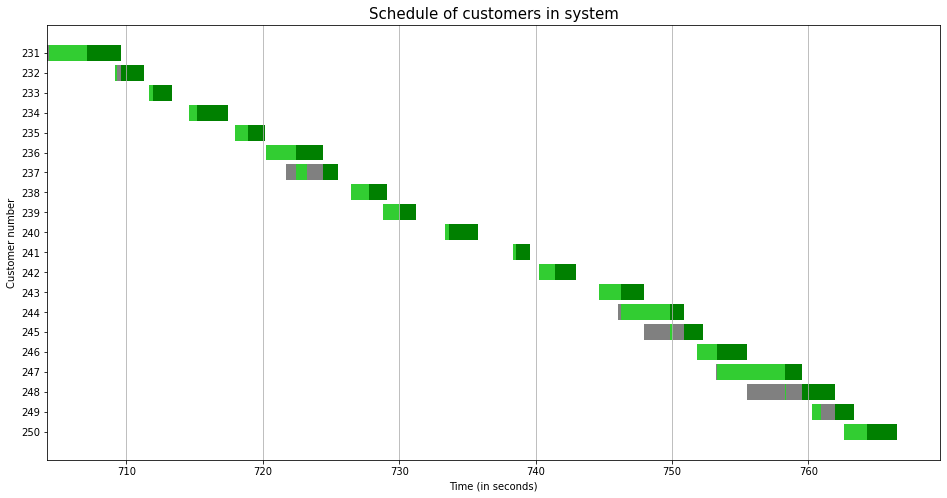

In [16]:
# The hard part: Plotting this so it looks good
# Okay I know this isn't strictly needed for the homework but I just really like how Gantt Charts look
cut = final[231:251]

plt.figure(figsize=(16,8))
plt.title("Schedule of customers in system", size=15)
plt.xlabel("Time (in seconds)")
plt.ylabel("Customer number")
plt.yticks(np.arange(min(cut.index), max(cut.index)+1, 1.0))
plt.barh(
    y = cut.index,
    left = cut["arrival_time"],
    width = cut["response_time"],
    alpha = 1.0,
    color = "gray"
)
plt.barh(
    y = cut.index,
    left = cut["start_time_1"],
    width = cut["service_time_1"],
    alpha = 1.0,
    color = "limegreen"
)
plt.barh(
    y = cut.index,
    left = cut["start_time_2"],
    width = cut["service_time_2"],
    alpha = 1.0,
    color = "green"
)
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.show()